In [1]:
import numpy as np
from magi1 import dynamic
from matplotlib import pyplot as plt
import torch
import gpytorch
import numpy as np
import torch.fft as ft
import time

from magi1.Inference import FTMAGI
from magi1 import dynamic

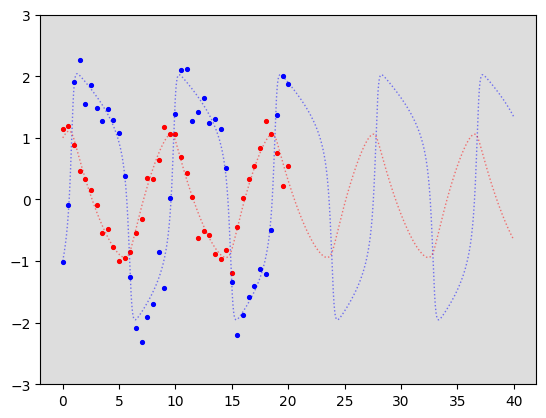

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20. ]


In [2]:
# FN
seed = 637077681 # random seed
example = 'fn' # example
noise = [0.2,0.2] # noise level
no_train = 41 # number of training point

# read data
data = np.loadtxt('data/%s.txt' %(example))
tdata = data[:,0] # time
xdata = data[:,1:] # component values
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)

# observation
obs = []
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))

# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.show()
print(tobs)

In [3]:
# known dynamic
torch.manual_seed(seed)
# define known FitzHugh-Nagumo dynamic
def FNode(theta, x):
    # theta: a, b, c; x: V, R
    dVdt = theta[2]*(x[:,0]-torch.pow(x[:,0],3)/3.0+x[:,1]).reshape(-1,1)
    dRdt = -1.0/theta[2]*(x[:,0]-theta[0]+theta[1]*x[:,1]).reshape(-1,1)
    dxdt = torch.cat((dVdt,dRdt), 1)
    return (dxdt)
theta = torch.tensor([1.,1.,5.]).double() # initial theta
fOde = dynamic.odeModule(FNode, theta)
# learning rate
magix_iteration = 1000
# time recording
start_time = time.time()
# call inference class
model = FTMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
# k for Fourier and z_t for Eigen
tinfer, xinfer,t1 = model.map(max_epoch=magix_iteration,
                        learning_rate=1e-2,
                        verbose=True,returnX=True,Truncated=True,k = 41,z_t = 81)
end_time = time.time()
run_time = end_time - start_time

  if nonzero_indices.storage():


1/1000 iteration: 51.120389
200/1000 iteration: 1.121208
400/1000 iteration: 0.778206
600/1000 iteration: 0.707823
800/1000 iteration: 0.685102
1000/1000 iteration: 0.676512
Time for optimization: 1.52


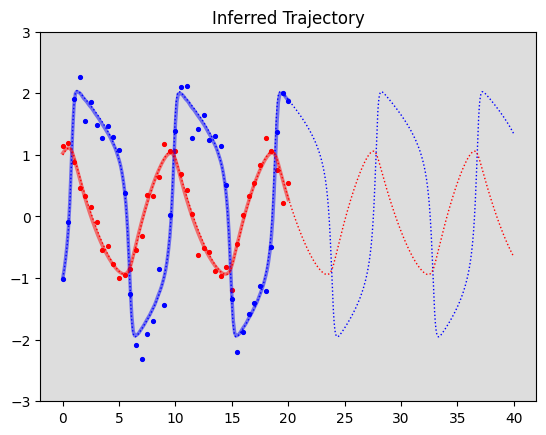

In [4]:
# inferred 
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tinfer, xinfer[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

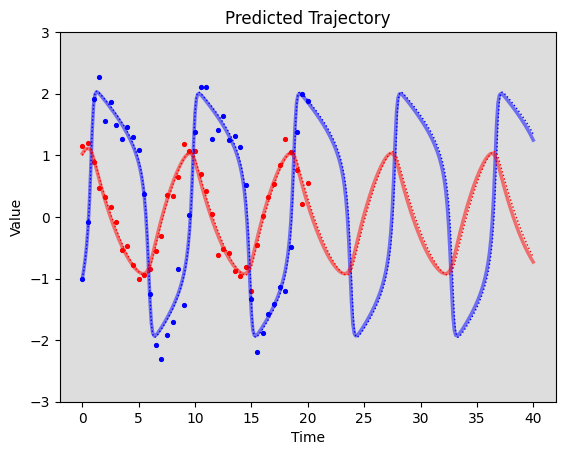

In [5]:
# Reconstructed trajectory 
trecon = tdata[np.linspace(0, tdata.size - 1, 321).astype(int)]
x0 = xinfer[0, :].squeeze()  # inferred initial state
xrecon = model.predict(x0, trecon)  # reconstructed trajectory

# Define colors and component labels
col = ['b', 'r', 'g']

# Create figure and axis
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

# Plot each component with its respective color
for i in range(no_comp):
    ax.plot(trecon, xrecon[:, i], color=col[i], alpha=0.5, lw=2.5)  # Add label for legend
    ax.plot(tdata, xdata[:, i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:, 0], obs[i][:, 1], s=7.5, marker='o', color=col[i])

# Set axis labels, limits, and title
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_ylim(-3, 3)


plt.title('Predicted Trajectory')
plt.show()